Downloading: "https://fypphotos.s3.amazonaws.com/resnet_model_final_presentation.pth" to /root/.cache/torch/hub/checkpoints/resnet_model_final_presentation.pth
100%|██████████| 90.0M/90.0M [00:01<00:00, 53.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Saving Screenshot 2023-09-20 at 11.01.03 PM.png to Screenshot 2023-09-20 at 11.01.03 PM.png
User uploaded file "Screenshot 2023-09-20 at 11.01.03 PM.png" with length 1099377 bytes


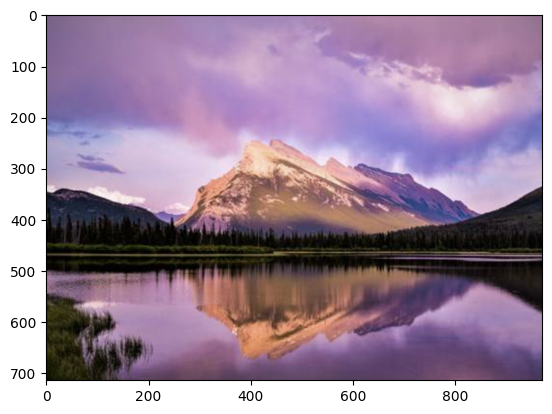

The image is scenic.


In [1]:
import torch
from torchvision.models import resnet50
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_URL = 'https://fypphotos.s3.amazonaws.com/resnet_model_final_presentation.pth'

# Load the model directly from the URL
model_weights = torch.hub.load_state_dict_from_url(MODEL_URL, map_location='cpu')

# Define the model architecture
fyp_model = resnet50(pretrained=False)
fyp_model.fc = torch.nn.Linear(2048, 2)  # Adjust the output layer

# Load the weights into the model
fyp_model.load_state_dict(model_weights)
fyp_model = fyp_model.to(device)




from PIL import Image  # Import the Image class
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
import io

import pandas as pd

transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # convert to RGB
    transforms.Resize((224, 224)),  # ResNet requires 224x224 images
    transforms.ToTensor(),
])


def predict_scenic(model, device, transform):
    # Create upload file field
    uploaded = files.upload()

    # Load and preprocess the uploaded image
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

        # Load the image and convert it to RGB
        image = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
        # Show the uploaded image
        plt.imshow(image)
        plt.show()
        # Apply the same transformations as during training
        image = transform(image)

        # Add an extra dimension for batch (ResNet expects a batch)
        image = image.unsqueeze(0)

        # Ensure the model is in evaluation mode
        model.eval()

        # Move the image to the device used during training (CPU or GPU)
        image = image.to(device)

        # Make the prediction
        output = model(image)

        # Convert output probabilities to predicted class (0 or 1)
        _, preds = torch.max(output, 1)

        # Output the prediction
        if preds.item() == 1:
            return 'The image is scenic.'
        else:
            return 'The image is not scenic.'

# Use the function
print(predict_scenic(fyp_model, device, transform))




In [15]:
!pip install gdown
!pip install requests
!pip install  Pillow

import gdown

url = 'https://drive.google.com/uc?id=1-39gatpZL3__lLx3CY90jJFqLxPQ3w8q'
output = 'selected_cases.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-39gatpZL3__lLx3CY90jJFqLxPQ3w8q
To: /content/selected_cases.csv
100%|██████████| 2.97k/2.97k [00:00<00:00, 11.3MB/s]


'selected_cases.csv'

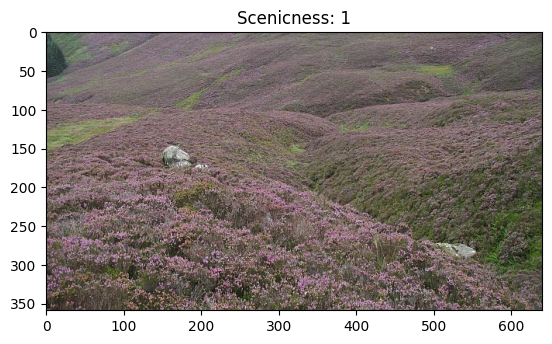

Comment: gully waist deep heather feed black burn scottish side knox knowe distinctly evil foot english side tough enough isolated outcrop boulder fell sandstone add fun
Average: 9.6
Predicted Scenicness: 0
Actual Scenicness: 1
The model's prediction deviated from the actual scenicness.


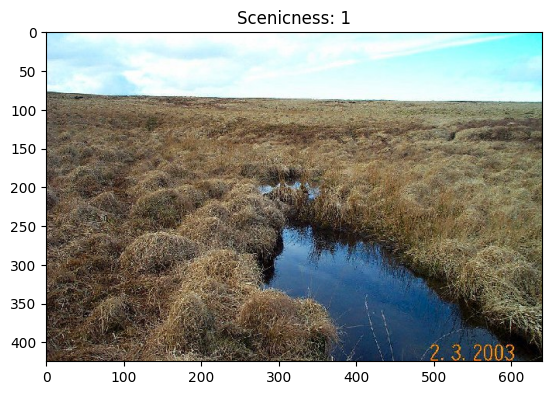

Comment: west dart head isolated place within grassy wilderness inner dartmor probably often visited tranquil seems far away rest devon sunny day ideal place spend time rain mist would atmosphere
Average: 6.4
Predicted Scenicness: 1
Actual Scenicness: 1
The model accurately predicted the scenicness.


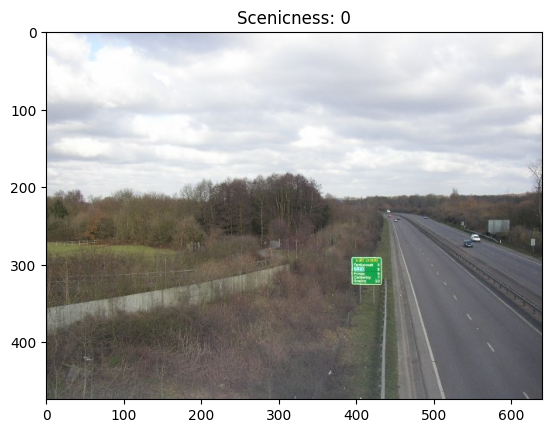

Comment: could road like yorkshire valley clogged buildings whereas blackwater valley wa relatively clear road ha built cutting embankment fence side lake wood valley still enjoyed photo wa taken looking northward footbridge accessed shawfield lane
Average: 2.25
Predicted Scenicness: 0
Actual Scenicness: 0
The model accurately predicted the scenicness.


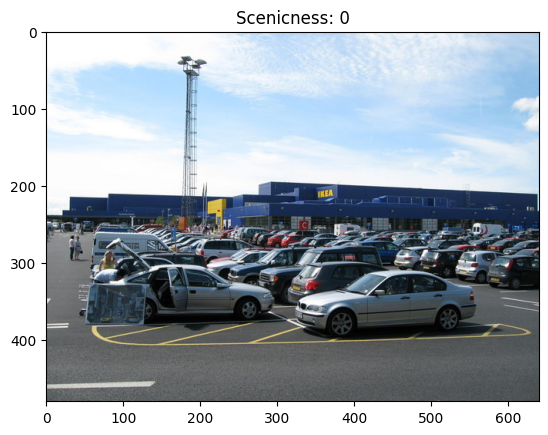

Comment: located next m62 huge ikea store gemini retail park \nthe warington store cover area 270 sq mts wa first ikea open united kingdom 1987 \ntoday 15 store dotted around united kingdom
Average: 1.0
Predicted Scenicness: 0
Actual Scenicness: 0
The model accurately predicted the scenicness.


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
from io import StringIO
from io import BytesIO


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
selected_df_read = pd.read_csv('selected_cases.csv')
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
# Iterate over the rows of the selected_df_read dataframe
for _, row in selected_df_read.iterrows():

    filename = row['filename']
    base_filename = os.path.basename(filename)
    img_path = 'https://fypphotos.s3.amazonaws.com/' + base_filename
    #os.path.join('/content/drive/MyDrive', row['filename'])
    #print(img_path)

    #url = img_path "https://fypphotos.s3.amazonaws.com/923658_369f4826.jpg"
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
    #img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Scenicness: {row['scenic']}")
    plt.show()
    print(f"Comment: {row['clean_comments']}")
    print(f"Average: {row['average']}")


    # 3. Model Predictions
    image_tensor = transform(img).unsqueeze(0).to(device)
    #transform(Image.open(img_path)).unsqueeze(0).to(device)
    outputs = fyp_model(image_tensor)
    predicted = torch.argmax(outputs, 1)
    print(f"Predicted Scenicness: {predicted.item()}")
    actual = row['scenic']
    predicted_value = predicted.item()

    if predicted_value == 1 and actual == 1:
        true_positives += 1
    elif predicted_value == 0 and actual == 0:
        true_negatives += 1
    elif predicted_value == 1 and actual == 0:
        false_positives += 1
    elif predicted_value == 0 and actual == 1:
        false_negatives += 1

    # 4. Discussion
    print(f"Actual Scenicness: {row['scenic']}")
    if predicted.item() == row['scenic']:
        print("The model accurately predicted the scenicness.")
    else:
        print("The model's prediction deviated from the actual scenicness.")



In [ ]:
# precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
# recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0
# accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
# f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"Accuracy: {accuracy}")
# print(f"F1 Score: {f1_score}")


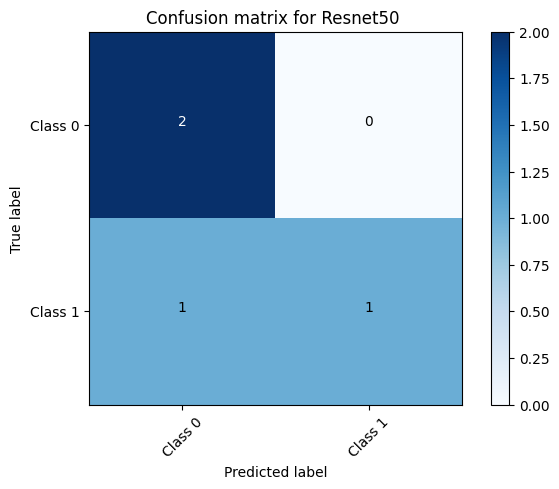

Accuracy: 0.75


In [22]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare the predicted and true labels for the confusion matrix
predicted_labels = []
true_labels = []
for _, row in selected_df_read.iterrows():
    true_labels.append(row['scenic'])

# For predicted labels, since you already calculated TP, TN, FP, FN
predicted_labels.extend([1]*true_positives)
predicted_labels.extend([0]*true_negatives)
predicted_labels.extend([1]*false_positives)
predicted_labels.extend([0]*false_negatives)

# Compute the confusion matrix and accuracy
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix for Resnet50 ', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Class 0', 'Class 1']
plot_confusion_matrix(cm, class_names)
plt.show()

print(f"Accuracy: {accuracy:.2f}")
